# Quantum Optics NN Project: Inverse Design of Circuit Parameters from Wigner Functions

This Jupyter notebook provides a complete end-to-end workflow for the quantum optics hackathon project. The goal is to train a neural network (NN) to predict quantum circuit parameters (squeezing values, beam splitter angles/phases, and photon numbers) from images of Wigner functions representing non-Gaussian quantum states.

The notebook is divided into sections :

- Section 1: Import Libraries
- Section 2: Define Circuit Parameters and Bounds
- Section 3: Generate Training Data
- Section 4: Load and Explore Data
- Section 5: Prepare Data for PyTorch
- Section 6: Define the Neural Network Model
- Section 7: Train the Model




 We'll use:

MrMustard for simulating continuous-variable (CV) quantum circuits and generating Wigner functions.
NumPy for data handling and saving/loading.
PyTorch for building and training the NN (as per your preference).
Matplotlib for visualizations.

### Prerequisites

In [12]:
# !pip install numpy matplotlib torch
# !pip install "mrmustard @ git+https://github.com/XanaduAI/MrMustard.git"

## Section 1: Import Libraries

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mrmustard.lab import Circuit, SqueezedVacuum, Number, BSgate
from mrmustard.physics.wigner import wigner_discretized
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # For progress bars

- MrMustard components for quantum simulation.
- PyTorch for NN and data loading.
- tqdm for monitoring loops (e.g., data generation, training).

## Section 2: Define Circuit Parameters and Bounds

In [14]:
# Circuit configuration
N_MODES = 3  # Number of modes (increase cautiously; computational cost grows)
MAX_R = 0.8  # Max squeezing parameter (real, absolute value)
MAX_N = 3    # Max photons per detector

# Wigner function discretization
PHASE_SPACE_CUTOFF = 3.0  # x and p bounds: [-cutoff, cutoff]
NUM_PIXELS = 15            # Pixels per axis (15x15 image)

# Data generation
NUM_SAMPLES = 10000  # Number of training samples to generate (adjust based on time/hardware)
DATA_FILE = "qst_hack_training_data.npz"  # File to save/load data

# Random seed for reproducibility
SEED = 42
np.random.seed(SEED)

- Bounds ensure simulations are tractable (as per project: high squeezing/photons increase complexity due to larger Fock space).
- Wigner images are 15x15 pixels, flattened to 225 features for NN input.
- We'll generate 1000 samples; this might take 10-30 minutes depending on hardware.
- Data saved as compressed .npz for efficiency.

## Section 3: Generate Training Data
This section simulates quantum circuits with random parameters, computes the conditional states, generates Wigner functions, and collects data.

In [15]:
# Section 3: Generate Training Data (FIXED VERSION)

def generate_random_params(rng):
    """Generate random circuit parameters within bounds."""
    # Squeezing parameters: uniform [0, MAX_R]
    squeezing_params = rng.uniform(0, MAX_R, size=N_MODES)
    
    # Beam splitter parameters: 3 BS for 3-mode interferometer
    # Each BS: theta [0, pi/2], phi [0, 2pi)
    bs_params = []
    for _ in range(3):  # Fixed to 3 BS as in snippet
        theta = rng.uniform(0, np.pi/2)
        phi = rng.uniform(0, 2*np.pi)
        bs_params.append([theta, phi])
    
    # Photon numbers: integers [0, MAX_N] for N-1 detectors
    photon_numbers = rng.integers(0, MAX_N + 1, size=N_MODES - 1)
    
    return squeezing_params, bs_params, photon_numbers

def build_circuit(squeezing_params, bs_params, photon_numbers):
    """Build and execute the CV circuit using MrMustard."""
    # Input states: Squeezed vacuums with alternating phases
    input_state = [
        SqueezedVacuum(i, r, phi=(0 if i % 2 == 1 else np.pi/2))
        for i, r in enumerate(squeezing_params)
    ]
    
    # Interferometer: Specific BS sequence (0-1, 1-2, 0-1)
    BS1 = BSgate([0, 1], *bs_params[0])
    BS2 = BSgate([1, 2], *bs_params[1])
    BS3 = BSgate([0, 1], *bs_params[2])
    interferometer = BS1 >> BS2 >> BS3
    
    # Measurements: PNRDs on first N-1 modes
    measurement = [Number(i, n).dual for i, n in enumerate(photon_numbers)]
    
    # Compose and contract circuit
    c = Circuit(input_state) >> interferometer >> Circuit(measurement)
    out = c.contract().normalize()
    
    return out

def compute_wigner(out_state):
    """Compute discretized Wigner function."""
    xvec = np.linspace(-PHASE_SPACE_CUTOFF, PHASE_SPACE_CUTOFF, NUM_PIXELS)
    pvec = np.linspace(-PHASE_SPACE_CUTOFF, PHASE_SPACE_CUTOFF, NUM_PIXELS)
    wig, _, _ = wigner_discretized(out_state.dm().ansatz.array, xvec, pvec)
    
    # Check for NaN/Inf and skip this sample if invalid
    if np.isnan(wig).any() or np.isinf(wig).any():
        return None
    
    return wig

# Generate data
rng = np.random.default_rng(SEED)
images = []
params_list = []
skipped_count = 0

print(f"Generating {NUM_SAMPLES} samples...")
for _ in tqdm(range(NUM_SAMPLES)):
    sq_params, bs_params, ph_numbers = generate_random_params(rng)
    
    # Flatten params into a single vector (shape: 11 for 3-mode: 3 r + 6 BS + 2 n)
    flat_params = np.concatenate([sq_params, np.array(bs_params).flatten(), ph_numbers])
    
    try:
        out_state = build_circuit(sq_params, bs_params, ph_numbers)
        wig = compute_wigner(out_state)
        
        # Skip invalid samples
        if wig is None:
            skipped_count += 1
            continue
            
        images.append(wig)
        params_list.append(flat_params)
    except Exception as e:
        # Skip samples that cause errors
        skipped_count += 1
        continue

# Convert to NumPy arrays
X = np.array(images)
y = np.array(params_list)

# Double-check: Remove any remaining NaN/Inf
valid_indices = ~(np.isnan(X).any(axis=(1,2)) | np.isinf(X).any(axis=(1,2)))
X = X[valid_indices]
y = y[valid_indices]

print(f"Valid samples: {len(X)} out of {NUM_SAMPLES} (skipped: {skipped_count})")

# Save as compressed .npz
np.savez_compressed(DATA_FILE, images=X, params=y)

print(f"Data saved to {DATA_FILE}. Shapes: X={X.shape}, y={y.shape}")

Generating 10000 samples...


  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\mhdri\AppData\Roaming\Python\Python310\site-packages\mrmustard\physics\ansatz\array_ansatz.py:260: UserWarning: The fock array is being padded with zeros. Is this really necessary?
  warn(
  0%|          | 15/10000 [00:00<01:08, 145.41it/s]C:\Users\mhdri\AppData\Roaming\Python\Python310\site-packages\mrmustard\physics\ansatz\array_ansatz.py:397: RuntimeWarning: invalid value encountered in divide
  return ArrayAnsatz(array=self.array / other, batch_dims=self.batch_dims)
100%|██████████| 10000/10000 [01:14<00:00, 134.50it/s]


Valid samples: 9861 out of 10000 (skipped: 139)
Data saved to qst_hack_training_data.npz. Shapes: X=(9861, 15, 15), y=(9861, 11)


- Parameter Generation: Randomizes within bounds; flattens to 11 values (3 squeezing + 3*2 BS params + 2 photons).
- Circuit Building: Matches the provided snippet (alternating phases, specific BS topology).
- Wigner Computation: Discretizes to 15x15 grid.
- Data Collection: Loops to generate samples; uses tqdm for progress.
- Saving: Uses np.savez_compressed for efficiency (reduces file size, as noted in the image).
- Potential Issues: If generation is slow, reduce NUM_SAMPLES or N_MODES. Rare measurements might yield noisy states—consider filtering if Wigner norms are off (optional extension).

## Section 4: Load and Explore Data

Loaded data. Shapes: X=(9861, 15, 15), y=(9861, 11)


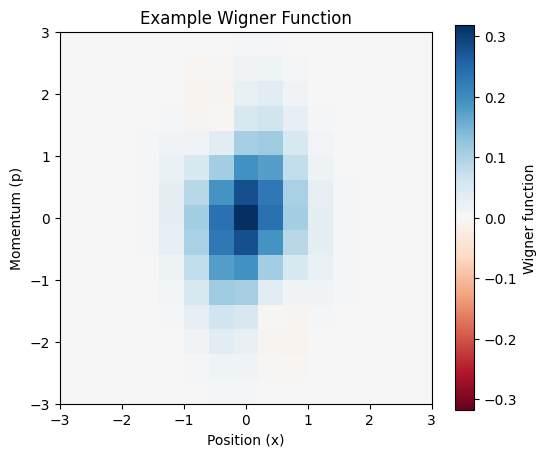

Corresponding parameters: [0.61916484 0.35110275 0.68687834 1.09542314 0.59173373 1.53250401
 4.78238179 1.23474692 0.80496169 3.         1.        ]


In [16]:
# Load data
data = np.load(DATA_FILE)
X = data['images']  # Shape: (num_samples, 15, 15)
y = data['params']   # Shape: (num_samples, 11)

print(f"Loaded data. Shapes: X={X.shape}, y={y.shape}")

# Example: Visualize first Wigner and its params
plt.figure(figsize=(6, 5))
plt.imshow(X[0].T, vmin=-1/np.pi, vmax=1/np.pi, cmap='RdBu', origin='lower',
           extent=[-PHASE_SPACE_CUTOFF, PHASE_SPACE_CUTOFF, -PHASE_SPACE_CUTOFF, PHASE_SPACE_CUTOFF])
plt.colorbar(label='Wigner function')
plt.xlabel('Position (x)')
plt.ylabel('Momentum (p)')
plt.title('Example Wigner Function')
plt.show()

print("Corresponding parameters:", y[0])



- Loading uses np.load, as in the image.
- Ensures X[i] and y[i] correspond to the same circuit (no de-sync risk).
- Visualization builds intuition: Look for negativities indicating non-Gaussianity.
- Why this format? Memory efficient, easy integration with PyTorch (as per image).

## Section 5: Prepare Data for PyTorch
Convert NumPy arrays to PyTorch tensors and create a DataLoader.
Python

In [17]:
# Section 5: Prepare Data for PyTorch (FIXED VERSION)

# Load data
data = np.load(DATA_FILE)
X = data['images']
y = data['params']

print(f"Loaded data: X={X.shape}, y={y.shape}")

# Normalize images to prevent NaN during training
X_mean = X.mean()
X_std = X.std()
X = (X - X_mean) / (X_std + 1e-8)  # Add small epsilon to prevent division by zero

# Normalize target parameters
y_mean = y.mean(axis=0)
y_std = y.std(axis=0)
y = (y - y_mean) / (y_std + 1e-8)  # Add small epsilon to prevent division by zero

print(f"After normalization:")
print(f"  X - min: {X.min():.4f}, max: {X.max():.4f}, mean: {X.mean():.4f}, std: {X.std():.4f}")
print(f"  y - min: {y.min():.4f}, max: {y.max():.4f}, mean: {y.mean():.4f}, std: {y.std():.4f}")

# Flatten Wigner images: (N, 15, 15) -> (N, 225)
X_flat = X.reshape(X.shape[0], -1)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_flat, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

print(f"Tensor shapes: X={X_tensor.shape}, y={y_tensor.shape}")

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
BATCH_SIZE = 32
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"DataLoader ready with batch size {BATCH_SIZE}.")

Loaded data: X=(9861, 15, 15), y=(9861, 11)
After normalization:
  X - min: -5.9749, max: 10.6952, mean: 0.0000, std: 1.0000
  y - min: -1.7661, max: 1.7465, mean: 0.0000, std: 1.0000
Tensor shapes: X=torch.Size([9861, 225]), y=torch.Size([9861, 11])
DataLoader ready with batch size 32.


- Tensors: Float32 for NN compatibility.
- Normalization: Wigner values are bounded; scaling helps NN convergence.
- TensorDataset: Directly uses NumPy arrays, as highlighted in the image.
- Batch size 32: Standard; adjust for GPU/memory.

## Section 6: Define the Neural Network Model
Build a simple CNN for image-to-params regression.
Python

In [18]:
# Section 6: Define the Neural Network Model (FIXED VERSION)

class WignerToParamsNN(nn.Module):
    def __init__(self, input_size=225, output_size=11):
        super(WignerToParamsNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)  # Add batch normalization
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)  # Add batch normalization
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)  # Add batch normalization
        self.fc4 = nn.Linear(128, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# Instantiate model
model = WignerToParamsNN()
print("Model architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total trainable parameters: {total_params:,}")

Model architecture:
WignerToParamsNN(
  (fc1): Linear(in_features=225, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=11, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
Total trainable parameters: 283,147


- Architecture: CNN suits image inputs (Wigner pixels). Two conv layers extract features (e.g., shapes, negativities), followed by fully connected for regression.
- Output: 11 continuous values; no activation on final layer (regression).
- Customization: For better performance, add more layers or use ResNet. Constrain outputs (e.g., sigmoid for bounded params) in extensions.
- Input shape: Unsqueeze to add channel (grayscale image).

## Section 7: Train the Model
Set up optimizer, loss, and training loop.
Python

Starting training for 100 epochs...


Epoch 1/100: 100%|██████████| 309/309 [00:02<00:00, 107.45it/s]


Epoch 1/100, Loss: 1.043427
  -> New best model saved (loss: 1.043427)


Epoch 2/100: 100%|██████████| 309/309 [00:02<00:00, 106.39it/s]


Epoch 2/100, Loss: 0.991903
  -> New best model saved (loss: 0.991903)


Epoch 3/100: 100%|██████████| 309/309 [00:02<00:00, 109.48it/s]


Epoch 3/100, Loss: 0.973991
  -> New best model saved (loss: 0.973991)


Epoch 4/100: 100%|██████████| 309/309 [00:02<00:00, 111.41it/s]


Epoch 4/100, Loss: 0.965070
  -> New best model saved (loss: 0.965070)


Epoch 5/100: 100%|██████████| 309/309 [00:02<00:00, 113.62it/s]


Epoch 5/100, Loss: 0.955656
  -> New best model saved (loss: 0.955656)


Epoch 6/100: 100%|██████████| 309/309 [00:02<00:00, 113.14it/s]


Epoch 6/100, Loss: 0.950170
  -> New best model saved (loss: 0.950170)


Epoch 7/100: 100%|██████████| 309/309 [00:02<00:00, 109.83it/s]


Epoch 7/100, Loss: 0.946200
  -> New best model saved (loss: 0.946200)


Epoch 8/100: 100%|██████████| 309/309 [00:02<00:00, 106.99it/s]


Epoch 8/100, Loss: 0.940222
  -> New best model saved (loss: 0.940222)


Epoch 9/100: 100%|██████████| 309/309 [00:02<00:00, 103.54it/s]


Epoch 9/100, Loss: 0.937440
  -> New best model saved (loss: 0.937440)


Epoch 10/100: 100%|██████████| 309/309 [00:02<00:00, 113.18it/s]


Epoch 10/100, Loss: 0.934347
  -> New best model saved (loss: 0.934347)


Epoch 11/100: 100%|██████████| 309/309 [00:02<00:00, 109.83it/s]


Epoch 11/100, Loss: 0.934017
  -> New best model saved (loss: 0.934017)


Epoch 12/100: 100%|██████████| 309/309 [00:01<00:00, 165.36it/s]


Epoch 12/100, Loss: 0.930162
  -> New best model saved (loss: 0.930162)


Epoch 13/100: 100%|██████████| 309/309 [00:01<00:00, 166.73it/s]


Epoch 13/100, Loss: 0.928553
  -> New best model saved (loss: 0.928553)


Epoch 14/100: 100%|██████████| 309/309 [00:01<00:00, 161.77it/s]


Epoch 14/100, Loss: 0.926654
  -> New best model saved (loss: 0.926654)


Epoch 15/100: 100%|██████████| 309/309 [00:01<00:00, 162.72it/s]


Epoch 15/100, Loss: 0.925722
  -> New best model saved (loss: 0.925722)


Epoch 16/100: 100%|██████████| 309/309 [00:01<00:00, 161.00it/s]


Epoch 16/100, Loss: 0.923310
  -> New best model saved (loss: 0.923310)


Epoch 17/100: 100%|██████████| 309/309 [00:01<00:00, 170.76it/s]


Epoch 17/100, Loss: 0.923016
  -> New best model saved (loss: 0.923016)


Epoch 18/100: 100%|██████████| 309/309 [00:01<00:00, 167.47it/s]


Epoch 18/100, Loss: 0.922396
  -> New best model saved (loss: 0.922396)


Epoch 19/100: 100%|██████████| 309/309 [00:01<00:00, 166.23it/s]


Epoch 19/100, Loss: 0.920301
  -> New best model saved (loss: 0.920301)


Epoch 20/100: 100%|██████████| 309/309 [00:02<00:00, 154.17it/s]


Epoch 20/100, Loss: 0.917862
  -> New best model saved (loss: 0.917862)


Epoch 21/100: 100%|██████████| 309/309 [00:01<00:00, 161.56it/s]


Epoch 21/100, Loss: 0.918033


Epoch 22/100: 100%|██████████| 309/309 [00:02<00:00, 131.81it/s]


Epoch 22/100, Loss: 0.915183
  -> New best model saved (loss: 0.915183)


Epoch 23/100: 100%|██████████| 309/309 [00:02<00:00, 113.76it/s]


Epoch 23/100, Loss: 0.916677


Epoch 24/100: 100%|██████████| 309/309 [00:03<00:00, 99.24it/s] 


Epoch 24/100, Loss: 0.916080


Epoch 25/100: 100%|██████████| 309/309 [00:03<00:00, 96.47it/s] 


Epoch 25/100, Loss: 0.913275
  -> New best model saved (loss: 0.913275)


Epoch 26/100: 100%|██████████| 309/309 [00:03<00:00, 101.47it/s]


Epoch 26/100, Loss: 0.913132
  -> New best model saved (loss: 0.913132)


Epoch 27/100: 100%|██████████| 309/309 [00:03<00:00, 97.38it/s]


Epoch 27/100, Loss: 0.912337
  -> New best model saved (loss: 0.912337)


Epoch 28/100: 100%|██████████| 309/309 [00:03<00:00, 100.69it/s]


Epoch 28/100, Loss: 0.912806


Epoch 29/100: 100%|██████████| 309/309 [00:03<00:00, 97.06it/s] 


Epoch 29/100, Loss: 0.911507
  -> New best model saved (loss: 0.911507)


Epoch 30/100: 100%|██████████| 309/309 [00:03<00:00, 96.57it/s] 


Epoch 30/100, Loss: 0.909451
  -> New best model saved (loss: 0.909451)


Epoch 31/100: 100%|██████████| 309/309 [00:03<00:00, 100.23it/s]


Epoch 31/100, Loss: 0.910491


Epoch 32/100: 100%|██████████| 309/309 [00:02<00:00, 104.07it/s]


Epoch 32/100, Loss: 0.911713


Epoch 33/100: 100%|██████████| 309/309 [00:02<00:00, 104.21it/s]


Epoch 33/100, Loss: 0.908713
  -> New best model saved (loss: 0.908713)


Epoch 34/100: 100%|██████████| 309/309 [00:03<00:00, 96.60it/s]


Epoch 34/100, Loss: 0.908961


Epoch 35/100: 100%|██████████| 309/309 [00:03<00:00, 96.42it/s] 


Epoch 35/100, Loss: 0.906621
  -> New best model saved (loss: 0.906621)


Epoch 36/100: 100%|██████████| 309/309 [00:03<00:00, 99.46it/s] 


Epoch 36/100, Loss: 0.906223
  -> New best model saved (loss: 0.906223)


Epoch 37/100: 100%|██████████| 309/309 [00:03<00:00, 99.08it/s] 


Epoch 37/100, Loss: 0.906652


Epoch 38/100: 100%|██████████| 309/309 [00:03<00:00, 101.23it/s]


Epoch 38/100, Loss: 0.905746
  -> New best model saved (loss: 0.905746)


Epoch 39/100: 100%|██████████| 309/309 [00:03<00:00, 98.00it/s] 


Epoch 39/100, Loss: 0.905750


Epoch 40/100: 100%|██████████| 309/309 [00:03<00:00, 95.18it/s] 


Epoch 40/100, Loss: 0.906032


Epoch 41/100: 100%|██████████| 309/309 [00:03<00:00, 96.35it/s] 


Epoch 41/100, Loss: 0.904305
  -> New best model saved (loss: 0.904305)


Epoch 42/100: 100%|██████████| 309/309 [00:03<00:00, 97.99it/s] 


Epoch 42/100, Loss: 0.904560


Epoch 43/100: 100%|██████████| 309/309 [00:03<00:00, 98.94it/s] 


Epoch 43/100, Loss: 0.903913
  -> New best model saved (loss: 0.903913)


Epoch 44/100: 100%|██████████| 309/309 [00:03<00:00, 98.15it/s] 


Epoch 44/100, Loss: 0.903654
  -> New best model saved (loss: 0.903654)


Epoch 45/100: 100%|██████████| 309/309 [00:03<00:00, 99.10it/s] 


Epoch 45/100, Loss: 0.903002
  -> New best model saved (loss: 0.903002)


Epoch 46/100: 100%|██████████| 309/309 [00:03<00:00, 96.91it/s] 


Epoch 46/100, Loss: 0.903079


Epoch 47/100: 100%|██████████| 309/309 [00:03<00:00, 96.29it/s] 


Epoch 47/100, Loss: 0.902387
  -> New best model saved (loss: 0.902387)


Epoch 48/100: 100%|██████████| 309/309 [00:03<00:00, 100.87it/s]


Epoch 48/100, Loss: 0.903293


Epoch 49/100: 100%|██████████| 309/309 [00:03<00:00, 100.91it/s]


Epoch 49/100, Loss: 0.900480
  -> New best model saved (loss: 0.900480)


Epoch 50/100: 100%|██████████| 309/309 [00:02<00:00, 104.97it/s]


Epoch 50/100, Loss: 0.901046


Epoch 51/100: 100%|██████████| 309/309 [00:02<00:00, 110.73it/s]


Epoch 51/100, Loss: 0.900471
  -> New best model saved (loss: 0.900471)


Epoch 52/100: 100%|██████████| 309/309 [00:02<00:00, 103.63it/s]


Epoch 52/100, Loss: 0.900715


Epoch 53/100: 100%|██████████| 309/309 [00:03<00:00, 102.61it/s]


Epoch 53/100, Loss: 0.900573


Epoch 54/100: 100%|██████████| 309/309 [00:02<00:00, 104.03it/s]


Epoch 54/100, Loss: 0.898920
  -> New best model saved (loss: 0.898920)


Epoch 55/100: 100%|██████████| 309/309 [00:02<00:00, 103.67it/s]


Epoch 55/100, Loss: 0.900016


Epoch 56/100: 100%|██████████| 309/309 [00:02<00:00, 103.08it/s]


Epoch 56/100, Loss: 0.898361
  -> New best model saved (loss: 0.898361)


Epoch 57/100: 100%|██████████| 309/309 [00:03<00:00, 99.53it/s] 


Epoch 57/100, Loss: 0.898370


Epoch 58/100: 100%|██████████| 309/309 [00:03<00:00, 99.42it/s] 


Epoch 58/100, Loss: 0.898310
  -> New best model saved (loss: 0.898310)


Epoch 59/100: 100%|██████████| 309/309 [00:02<00:00, 104.72it/s]


Epoch 59/100, Loss: 0.898835


Epoch 60/100: 100%|██████████| 309/309 [00:02<00:00, 106.13it/s]


Epoch 60/100, Loss: 0.899009


Epoch 61/100: 100%|██████████| 309/309 [00:02<00:00, 108.34it/s]


Epoch 61/100, Loss: 0.896503
  -> New best model saved (loss: 0.896503)


Epoch 62/100: 100%|██████████| 309/309 [00:02<00:00, 109.48it/s]


Epoch 62/100, Loss: 0.896912


Epoch 63/100: 100%|██████████| 309/309 [00:03<00:00, 101.36it/s]


Epoch 63/100, Loss: 0.897384


Epoch 64/100: 100%|██████████| 309/309 [00:03<00:00, 101.39it/s]


Epoch 64/100, Loss: 0.896933


Epoch 65/100: 100%|██████████| 309/309 [00:02<00:00, 107.60it/s]


Epoch 65/100, Loss: 0.895920
  -> New best model saved (loss: 0.895920)


Epoch 66/100: 100%|██████████| 309/309 [00:02<00:00, 106.68it/s]


Epoch 66/100, Loss: 0.895076
  -> New best model saved (loss: 0.895076)


Epoch 67/100: 100%|██████████| 309/309 [00:02<00:00, 103.74it/s]


Epoch 67/100, Loss: 0.895627


Epoch 68/100: 100%|██████████| 309/309 [00:02<00:00, 107.78it/s]


Epoch 68/100, Loss: 0.893811
  -> New best model saved (loss: 0.893811)


Epoch 69/100: 100%|██████████| 309/309 [00:02<00:00, 103.55it/s]


Epoch 69/100, Loss: 0.895616


Epoch 70/100: 100%|██████████| 309/309 [00:02<00:00, 104.48it/s]


Epoch 70/100, Loss: 0.894536


Epoch 71/100: 100%|██████████| 309/309 [00:02<00:00, 108.90it/s]


Epoch 71/100, Loss: 0.893679
  -> New best model saved (loss: 0.893679)


Epoch 72/100: 100%|██████████| 309/309 [00:02<00:00, 108.07it/s]


Epoch 72/100, Loss: 0.895511


Epoch 73/100: 100%|██████████| 309/309 [00:02<00:00, 103.11it/s]


Epoch 73/100, Loss: 0.893462
  -> New best model saved (loss: 0.893462)


Epoch 74/100: 100%|██████████| 309/309 [00:02<00:00, 109.96it/s]


Epoch 74/100, Loss: 0.893085
  -> New best model saved (loss: 0.893085)


Epoch 75/100: 100%|██████████| 309/309 [00:02<00:00, 106.95it/s]


Epoch 75/100, Loss: 0.892412
  -> New best model saved (loss: 0.892412)


Epoch 76/100: 100%|██████████| 309/309 [00:02<00:00, 104.84it/s]


Epoch 76/100, Loss: 0.893524


Epoch 77/100: 100%|██████████| 309/309 [00:02<00:00, 107.56it/s]


Epoch 77/100, Loss: 0.893674


Epoch 78/100: 100%|██████████| 309/309 [00:02<00:00, 145.07it/s]


Epoch 78/100, Loss: 0.892185
  -> New best model saved (loss: 0.892185)


Epoch 79/100: 100%|██████████| 309/309 [00:02<00:00, 144.67it/s]


Epoch 79/100, Loss: 0.891561
  -> New best model saved (loss: 0.891561)


Epoch 80/100: 100%|██████████| 309/309 [00:02<00:00, 142.79it/s]


Epoch 80/100, Loss: 0.892275


Epoch 81/100: 100%|██████████| 309/309 [00:01<00:00, 156.86it/s]


Epoch 81/100, Loss: 0.890588
  -> New best model saved (loss: 0.890588)


Epoch 82/100: 100%|██████████| 309/309 [00:01<00:00, 165.83it/s]


Epoch 82/100, Loss: 0.891360


Epoch 83/100: 100%|██████████| 309/309 [00:01<00:00, 168.29it/s]


Epoch 83/100, Loss: 0.889978
  -> New best model saved (loss: 0.889978)


Epoch 84/100: 100%|██████████| 309/309 [00:01<00:00, 171.89it/s]


Epoch 84/100, Loss: 0.890637


Epoch 85/100: 100%|██████████| 309/309 [00:01<00:00, 162.22it/s]


Epoch 85/100, Loss: 0.891005


Epoch 86/100: 100%|██████████| 309/309 [00:01<00:00, 167.52it/s]


Epoch 86/100, Loss: 0.889096
  -> New best model saved (loss: 0.889096)


Epoch 87/100: 100%|██████████| 309/309 [00:01<00:00, 165.46it/s]


Epoch 87/100, Loss: 0.889331


Epoch 88/100: 100%|██████████| 309/309 [00:01<00:00, 158.77it/s]


Epoch 88/100, Loss: 0.889515


Epoch 89/100: 100%|██████████| 309/309 [00:01<00:00, 169.18it/s]


Epoch 89/100, Loss: 0.889514


Epoch 90/100: 100%|██████████| 309/309 [00:01<00:00, 164.89it/s]


Epoch 90/100, Loss: 0.889858


Epoch 91/100: 100%|██████████| 309/309 [00:01<00:00, 167.97it/s]


Epoch 91/100, Loss: 0.888450
  -> New best model saved (loss: 0.888450)


Epoch 92/100: 100%|██████████| 309/309 [00:01<00:00, 161.62it/s]


Epoch 92/100, Loss: 0.889830


Epoch 93/100: 100%|██████████| 309/309 [00:01<00:00, 157.39it/s]


Epoch 93/100, Loss: 0.888488


Epoch 94/100: 100%|██████████| 309/309 [00:02<00:00, 148.66it/s]


Epoch 94/100, Loss: 0.887861
  -> New best model saved (loss: 0.887861)


Epoch 95/100: 100%|██████████| 309/309 [00:02<00:00, 146.85it/s]


Epoch 95/100, Loss: 0.887382
  -> New best model saved (loss: 0.887382)


Epoch 96/100: 100%|██████████| 309/309 [00:01<00:00, 159.98it/s]


Epoch 96/100, Loss: 0.887177
  -> New best model saved (loss: 0.887177)


Epoch 97/100: 100%|██████████| 309/309 [00:01<00:00, 165.79it/s]


Epoch 97/100, Loss: 0.887069
  -> New best model saved (loss: 0.887069)


Epoch 98/100: 100%|██████████| 309/309 [00:01<00:00, 164.75it/s]


Epoch 98/100, Loss: 0.884936
  -> New best model saved (loss: 0.884936)


Epoch 99/100: 100%|██████████| 309/309 [00:01<00:00, 162.54it/s]


Epoch 99/100, Loss: 0.886314


Epoch 100/100: 100%|██████████| 309/309 [00:01<00:00, 161.67it/s]


Epoch 100/100, Loss: 0.887347
Training complete.
Best loss achieved: 0.884936


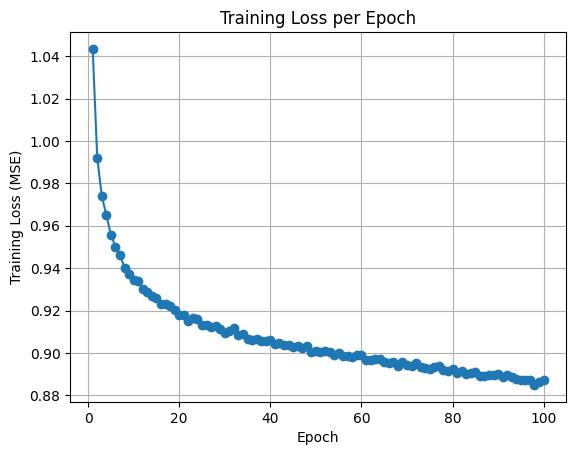

In [19]:
# Section 7: Train the Model (with loss curve)

import matplotlib.pyplot as plt
from tqdm import tqdm

EPOCHS = 100
LEARNING_RATE = 1e-4

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

model.train()
best_loss = float('inf')

train_losses = []  # <-- store avg loss per epoch

print(f"Starting training for {EPOCHS} epochs...")
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    used_batches = 0

    for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        optimizer.zero_grad()

        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        if torch.isnan(loss):
            print(f"WARNING: NaN loss detected at epoch {epoch+1}. Skipping batch.")
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()
        used_batches += 1

    avg_loss = epoch_loss / max(used_batches, 1)  # safer if everything got skipped
    train_losses.append(avg_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.6f}")
    scheduler.step(avg_loss)

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"  -> New best model saved (loss: {best_loss:.6f})")

print("Training complete.")
print(f"Best loss achieved: {best_loss:.6f}")

# Plot loss curve
plt.figure()
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Training Loss per Epoch")
plt.grid(True)
plt.show()


- Loss: MSE for continuous params. For photons (discrete), consider hybrid loss (e.g., CE on those columns).
- Optimizer: Adam is robust.
- Loop: Simple; add validation split for production.
- Evaluation: After training, test on holdout data (optional: split dataset 80/20).
- Constraints: Post-process outputs to bounds (e.g., clamp θ to [0, π/2]).

## Section 8: Evaluate and Predict
Test on a sample and visualize.
Python

In [20]:
# Section 8: Evaluate and Predict (FIXED VERSION)

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Example prediction with denormalization
with torch.no_grad():
    sample_idx = 0
    pred_normalized = model(X_tensor[sample_idx].unsqueeze(0)).squeeze().numpy()
    
    # Denormalize predictions back to original scale
    pred = pred_normalized * y_std + y_mean
    
    # Get true values (denormalized)
    true_normalized = y_tensor[sample_idx].numpy()
    true = true_normalized * y_std + y_mean

print("True params:", true)
print("Predicted params:", pred)
print("\nAbsolute errors:")
print(np.abs(pred - true))
print("\nMean absolute error:", np.mean(np.abs(pred - true)))

# Test on multiple samples
num_test_samples = 100
predictions = []
true_values = []

with torch.no_grad():
    for i in range(min(num_test_samples, len(X_tensor))):
        pred_normalized = model(X_tensor[i].unsqueeze(0)).squeeze().numpy()
        pred = pred_normalized * y_std + y_mean
        
        true_normalized = y_tensor[i].numpy()
        true = true_normalized * y_std + y_mean
        
        predictions.append(pred)
        true_values.append(true)

predictions = np.array(predictions)
true_values = np.array(true_values)

# Calculate metrics
mae = np.mean(np.abs(predictions - true_values), axis=0)
mse = np.mean((predictions - true_values)**2, axis=0)

print(f"\nMetrics over {num_test_samples} samples:")
print("Mean Absolute Error per parameter:", mae)
print("Mean Squared Error per parameter:", mse)
print("Overall MAE:", np.mean(mae))
print("Overall MSE:", np.mean(mse))

# Optional: Visualize predictions vs true values for each parameter
param_names = ['r1', 'r2', 'r3', 'θ1', 'φ1', 'θ2', 'φ2', 'θ3', 'φ3', 'n1', 'n2']
for i, name in enumerate(param_names):
    print(f"\n{name}: MAE={mae[i]:.4f}, MSE={mse[i]:.4f}")

True params: [0.61916483 0.35110276 0.68687832 1.09542313 0.59173384 1.53250402
 4.78238181 1.23474692 0.80496161 3.         1.        ]
Predicted params: [0.44896954 0.46141812 0.40221202 0.82549432 3.11647083 1.04926444
 2.896263   0.81923287 3.20493616 1.29733841 1.32750737]

Absolute errors:
[0.17019528 0.11031537 0.28466631 0.26992881 2.524737   0.48323957
 1.88611881 0.41551405 2.39997455 1.70266159 0.32750737]

Mean absolute error: 0.9613507912362802

Metrics over 100 samples:
Mean Absolute Error per parameter: [0.18705363 0.17270102 0.15469486 0.35290722 1.75692051 0.24823983
 1.53001079 0.39603591 1.51311639 0.88032979 0.81864587]
Mean Squared Error per parameter: [0.04783567 0.04277099 0.0420683  0.17812444 3.86165179 0.10325478
 3.06962234 0.21069977 3.02455729 1.02890265 0.9042564 ]
Overall MAE: 0.7282414383200826
Overall MSE: 1.1376131283239368

r1: MAE=0.1871, MSE=0.0478

r2: MAE=0.1727, MSE=0.0428

r3: MAE=0.1547, MSE=0.0421

θ1: MAE=0.3529, MSE=0.1781

φ1: MAE=1.7569, M

Switch to eval mode (no gradients).
Compare true vs predicted.
For full eval: Compute MSE per param type or quantum fidelity (using MrMustard on predicted circuit).